In [1]:
# default_exp fiducial_detect

# Import

In [2]:
# export
import warnings

import numpy as np
import torch
from PIL import Image
from skimage.measure import label, regionprops
from torchvision import transforms

from camera_calib_python.utils import *

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from camera_calib_python.image import File16bitImg

# Utility

In [4]:
# export
def imresize(arr, sz):
    pim = Image.fromarray(arr)
    pim = transforms.functional.resize(pim, sz)
    return np.array(pim)

In [5]:
# export
def normalize(arr, r1, r2):
    return (arr-r1[0])/(r1[1]-r1[0])*(r2[1]-r2[0])+r2[0]

# Dot vision checker board deep learning detector

This uses a neural net specifically trained on my dot vision checker board. Please look at :

https://github.com/justinblaber/fiducial_detect

For more info. torchscript is used so you don't have to define the model when you load it.

Note that `arr` needs to be a gray scale floating point image scaled between [0,1]

In [6]:
# export
class DotVisionCheckerDLDetector():
    def __init__(self, file_model, cuda=False):
        model = torch.jit.load(file_model.as_posix())
        model = model.cuda() if cuda else model.cpu()
        model = model.eval()
        
        self.cuda  = cuda
        self.model = model
        
    def format_arr(self, arr):
        assert_allclose(arr.dtype, np.float)        # Floating point check
        assert_allclose(len(arr.shape), 2)          # Grayscale check
        if arr.min() < 0: warnings.warn('Value less than zero detected')
        if arr.max() > 1: warnings.warn('Value greater than 1 detected')
        
        arr = imresize(arr, 384)                    # Network trained on grayscale 384 sized images
        arr = normalize(arr, (0, 1), (-1, 1))       # Network trained on images between [-1,1]
        arr = transforms.functional.to_tensor(arr)  # Tensorify
        arr = arr[None]                             # Add batch dimension
        if self.cuda: arr = arr.cuda()              # Possibly run on gpu
        return arr
        
    def get_mask(self, arr):
        model = self.model
        with torch.no_grad():
            mask = model(self.format_arr(arr))      # Inference
            mask = torch2np(mask)                   # Convert to numpy
            mask = mask.argmax(axis=1)              # Convert from scores to labels
            mask = mask.squeeze(0)                  # Remove batch dimension
        return mask
        
    def __call__(self, arr):
        mask = self.get_mask(arr)

        # Extract fiducial points from mask
        ps_f = np.full((4,2), np.nan)
        for idx, p_f in enumerate(ps_f):
            regions = regionprops(label(mask == (idx+1)))
            if len(regions) > 0:
                region = regions[np.argmax([r.area for r in regions])]
                p_f[:] = reverse(region.centroid)
        ps_f *= (np.array(arr.shape)/mask.shape).mean() # May not be strictly correct

        return ps_f

Test it

In [7]:
file_model = Path('models/dot_vision_checker.pth')
file_img = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')
ps_f_detector = DotVisionCheckerDLDetector(file_model)
img = File16bitImg(file_img)
ps_f = ps_f_detector(img.array_gs)
ps_f

array([[ 978.95726496,  516.94017094],
       [ 155.82366589,  497.67053364],
       [ 973.33673469, 1317.34693878],
       [ 192.2320442 , 1279.00552486]])

In [8]:
assert_allclose(ps_f, np.array([[ 979,  517],
                                [ 156,  498],
                                [ 973, 1317],
                                [ 192, 1279]]), atol=2)

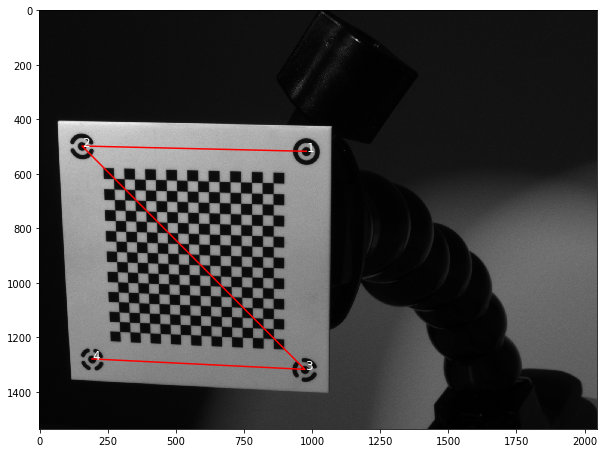

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(img.array_gs, cmap='gray')
for idx, p_f in enumerate(ps_f): 
    plt.text(p_f[0], p_f[1], str(idx+1), color='w', fontsize=12)
plt.plot(ps_f[:,0], ps_f[:,1], 'r')

# Build

In [10]:
!nbdev_build_lib

Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted coordinate_graph.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted test.ipynb.
Converted utils.ipynb.
